# Elo Code

In [1]:
from asyncio.windows_events import NULL
import numpy as np
from collections import Counter
from datetime import datetime as dt
import pickle
import bz2
import random
import math
from math import log
import seaborn as sns
import matplotlib.pyplot as plt

## Data Import

In [2]:
with open('/Users/mmaze/Desktop/vball_game_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball_train = pickle.load(uncompressed)
    
vball_train.sort(order='datetime')

In [3]:
with open('C:\\Users\\mmaze\\Desktop\\Capstone\\Elo\\train_and_test_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball_test = pickle.load(uncompressed)

#Sort by date (Final Array)
vball_test.sort(order='datetime')

In [4]:
print(len(vball_train))
print(len(vball_test))

206296
243568


In [5]:
# View examples of the data:

# row 0
print(vball_train[0])
print("")

# Equivalent output to a structured array
print(vball_train['tournament_name'][1])
print(vball_train[1]['tournament_name'])

# Calling multiple fields
print(vball_train[['tournament_name','type']][1])

(80, "25th Annual AAU Girls' Junior National Beach Volleyball Championships", 'National', '15U', '21', 'Girls', 'Juniors', 65, 1, 1, 'Home', 1, 'Pool', False, 400, 494, '400.494', 1816, 2144, '1816.2144', True, False, 21, 7, False, 21, 14, 0.75, 21, 33.862354, -118.40166, 'Pacific Standard Time', '2018-07-10T09:00:00.000000')

25th Annual AAU Girls' Junior National Beach Volleyball Championships
25th Annual AAU Girls' Junior National Beach Volleyball Championships
("25th Annual AAU Girls' Junior National Beach Volleyball Championships", 'National')


## Functions

In [6]:
# Elo probability, recreated from https://www.geeksforgeeks.org/elo-rating-algorithm/
def Probability(rating1, rating2):
    return 1.0 / (1 + (10 ** ((rating2 - rating1) / 400)))

def EloRating(Ra, Rb, K, won):
    # Probability of Player A
    Pa = Probability(Ra, Rb)
    # Case When Player A wins
    if (won) :
        Ra = Ra + K * (1 - Pa)
    # Case When Player A loses
    else :
        Ra = Ra + K * (0 - Pa)
    return(round(Ra, 4))

def LogLoss(outcome, prob):
    if outcome == True:
        result = 1
    else:
        result = 0
    return -1 * ((result * log(prob)) + ((1 - result) * log(1-prob)))

In [7]:
# Example Outputs:
print(Probability(1400, 1700))
print(Probability(1700, 1400))
print(EloRating(Ra=1100, Rb=1000, K=800, won=True))
print(EloRating(Ra=1100, Rb=1000, K=800, won=False))

0.15097955721132328
0.8490204427886767
1387.948
587.948


In [8]:
def simulator(match_data, inital_elo=1200, K=100, decay_amt=1, restore_amt=1):
    # elo_db:
    # a dictionary with player id as the key
    # the value is their elo
    elo_db = dict()
    loop = 0
    correct_counter = 0
    match_counter = 0
    total_log_loss = 0
    elo_w_outcome = list()

    if len(match_data) > 220000:
        acc_eval_row = 206296
        print("running on the test set")
    else:
        acc_eval_row = 120000
        print("running on the train set")

    last_dt = str(match_data[0][-1])[0:10]

    for match in match_data:
        if loop%4==0:
            
            # decay and restore
            if isinstance(decay_amt, float) | isinstance(restore_amt, float):
                # find date. Select [0:10] bc we only want the date not time
                current_dt = str(match[-1])[0:10]
                # if it is a new day then:
                if last_dt != current_dt:
                    last_dt = current_dt
                    for key, elo in elo_db.items():
                        if elo > inital_elo:
                            elo_db.update({key: elo*decay_amt})
                        if elo < inital_elo:
                            elo_db.update({key: elo*restore_amt})

            # add players to database if needed:
            for person in ["player_id", "teammate_id", "opponent1_id", "opponent2_id"]:
                if match[person] not in elo_db.keys():
                    elo_db.update({match[person]: inital_elo})
            # set parameters     
            avg_oppon = .5 * (elo_db.get(match["opponent1_id"]) + elo_db.get(match["opponent2_id"]))
            player_elo = .5 * (elo_db.get(match["player_id"]) + elo_db.get(match["teammate_id"]))

            # we will only record accuracy of games past the 206295th match
            # it will caputre the accuracy of 3/5/22 to 6/20/22 games
            if loop >= acc_eval_row:

                # skip over situations where both players are unranked or have same elo
                if player_elo == avg_oppon:
                    continue

                # compare preds to actual
                prob = Probability(player_elo, avg_oppon)
                total_log_loss += LogLoss(match["win"], prob)
                if prob > .5:
                    pred_win = True
                else:
                    pred_win = False

                # update accuracy/match counters
                if pred_win == match["win"]:
                    correct_counter += 1
                match_counter += 1

                # update elo_w_outcome
                # this is a list of lists with structure [outcome, pred_winner, pred_loser, probability]
                if (pred_win == match["win"]):
                    if (player_elo > avg_oppon):
                        elo_w_outcome.append([1, player_elo, avg_oppon, Probability(player_elo, avg_oppon)])
                    else:
                        elo_w_outcome.append([1, avg_oppon, player_elo, Probability(avg_oppon, player_elo)])
                if (pred_win != match["win"]):
                    if (player_elo > avg_oppon):
                        elo_w_outcome.append([0, player_elo, avg_oppon, Probability(player_elo, avg_oppon)])
                    else:
                        elo_w_outcome.append([0, avg_oppon, player_elo, Probability(avg_oppon, player_elo)])                   

            # perform calculations/updates
            # recall, match["win"] is from the player team's perspective
            if match["win"]:
                player_elo_adj = EloRating(player_elo, avg_oppon, K, True) - player_elo
                opp_elo_adj = EloRating(avg_oppon, player_elo, K, False) - avg_oppon
            else:
                player_elo_adj = EloRating(player_elo, avg_oppon, K, False) - player_elo
                opp_elo_adj = EloRating(avg_oppon, player_elo, K, True) - avg_oppon
            elo_db.update({match["player_id"]: elo_db.get(match["player_id"]) + player_elo_adj})
            elo_db.update({match["teammate_id"]: elo_db.get(match["teammate_id"]) + player_elo_adj})
            elo_db.update({match["opponent1_id"]: elo_db.get(match["opponent1_id"]) + opp_elo_adj})
            elo_db.update({match["opponent2_id"]: elo_db.get(match["opponent2_id"]) + opp_elo_adj})

        loop+=1
    log_loss = total_log_loss/match_counter
    return(correct_counter, match_counter, log_loss, elo_db, elo_w_outcome)

In [9]:
def random_search(match_data, num_iters, k_list, decay_amt_list, restore_amt_list):
    grid_search = dict()
    for _ in np.arange(num_iters):
        k = random.choice(k_list)
        decay_amt = random.choice(decay_amt_list)
        restore_amt = random.choice(restore_amt_list)
        print(k, decay_amt, restore_amt)

        output = simulator(
            match_data = match_data,
            K=k,
            decay_amt = decay_amt, 
            restore_amt = restore_amt)
        
        correct_counter, match_counter, log_loss, elo_db, elo_w_outcome = output
        grid_search.update({str([k, decay_amt, restore_amt]): round(correct_counter/match_counter, 5)})
    return max(grid_search.items(), key=lambda x: x[1]) 

In [10]:
def grid_search(match_data, k_list, decay_amt_list, restore_amt_list):
    grid_search = dict()
    for k in k_list:
        for decay_amt in decay_amt_list:
            for restore_amt in restore_amt_list:
                output = simulator(
                    match_data = match_data,
                    K=k,
                    decay_amt = decay_amt, 
                    restore_amt = restore_amt)
        
                correct_counter, match_counter, log_loss, elo_db, elo_w_outcome = output
                grid_search.update({str([k, decay_amt, restore_amt]): round(correct_counter/match_counter, 5)})
    return max(grid_search.items(), key=lambda x: x[1]) 

## hyper parameter search

In [12]:
random_search(
    match_data = vball_train,
    num_iters = 50, 
    k_list = [5, 10, 20, 25, 30, 40, 50, 60, 75, 100, 150, 200, 250, 300, 400], 
    decay_amt_list = np.arange(.9, .99, .01).tolist() + [1, 1, 1, 1, 1],
    restore_amt_list = np.arange(1.01, 1.1, .01).tolist() + [1, 1, 1, 1, 1]
)

300 0.9400000000000001 1
running on the train set
5 0.9700000000000001 1.09
running on the train set
60 0.9500000000000001 1
running on the train set
60 0.9800000000000001 1.02
running on the train set
5 0.9800000000000001 1.03
running on the train set
75 1 1.07
running on the train set
75 0.92 1
running on the train set
50 0.9500000000000001 1.03
running on the train set
30 1 1.06
running on the train set
150 0.9 1.08
running on the train set
5 0.92 1.03
running on the train set
250 0.9400000000000001 1.07
running on the train set
150 1 1.1
running on the train set
40 1 1.01
running on the train set
60 0.92 1.02
running on the train set
5 0.91 1.01
running on the train set
5 1 1.04
running on the train set
60 1 1
running on the train set
25 1 1
running on the train set
400 0.9600000000000001 1.03
running on the train set
40 0.9400000000000001 1.04
running on the train set
25 0.93 1.01
running on the train set
5 1 1
running on the train set
50 0.92 1
running on the train set
150 0.93 1

('[100, 1, 1.03]', 0.77087)

In [13]:
grid_search(
    match_data = vball_train,
    k_list = [90, 95, 100, 105, 100], 
    decay_amt_list = [.996, .997, .998, .999, 1],
    restore_amt_list = [1.024, 1.026, 1.028, 1.03, 1.032, 1.034, 1.036],
)

running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set
running on the train set


('[100, 1, 1.03]', 0.77087)

## Visualizations

In [26]:
correct_counter, match_counter, log_loss, elo_db, elo_w_outcome = simulator(match_data=vball_test, inital_elo=1200, K=100, decay_amt=1, restore_amt=1.03)
print("accuracy is", correct_counter/match_counter)
print("log loss is", log_loss)

running on the test set
accuracy is 0.7680937260483959
log loss is 0.4923231024459093


In [15]:
out_array_no_ties=np.array(elo_w_outcome)
out_array_no_ties[0:10]

array([[0.00000000e+00, 1.26313917e+03, 1.24143872e+03, 5.31188919e-01],
       [1.00000000e+00, 1.29455760e+03, 1.21002030e+03, 6.19313597e-01],
       [1.00000000e+00, 1.57104764e+03, 1.20000000e+03, 8.94345885e-01],
       [1.00000000e+00, 1.58161310e+03, 1.18943460e+03, 9.05300732e-01],
       [1.00000000e+00, 1.34147848e+03, 1.17195170e+03, 7.26288875e-01],
       [1.00000000e+00, 1.36884960e+03, 1.14458060e+03, 7.84315749e-01],
       [1.00000000e+00, 1.37643861e+03, 1.17996470e+03, 7.56022433e-01],
       [1.00000000e+00, 1.40083640e+03, 1.15556690e+03, 8.04063046e-01],
       [1.00000000e+00, 1.33262620e+03, 1.13597320e+03, 7.56212535e-01],
       [1.00000000e+00, 1.59108300e+03, 1.12301220e+03, 9.36697295e-01]])

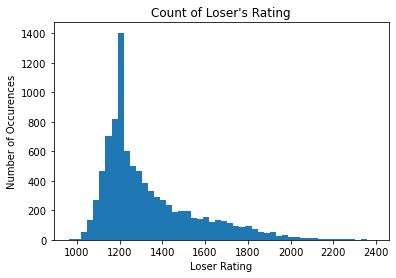

In [16]:
fig, ax = plt.subplots()
ax.hist(out_array_no_ties[:,2], bins = 50)
ax.title.set_text("Count of Loser's Rating")
ax.set_xlabel("Loser Rating")
ax.set_ylabel("Number of Occurences")
plt.show()

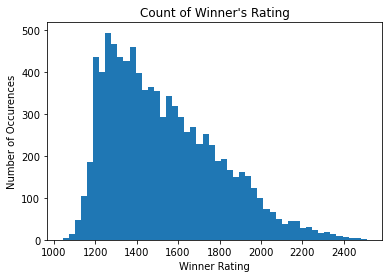

In [17]:
fig, ax = plt.subplots()
ax.hist(out_array_no_ties[:,1], bins = 50)
ax.title.set_text("Count of Winner's Rating")
ax.set_xlabel("Winner Rating")
ax.set_ylabel("Number of Occurences")
plt.show()

In [18]:
bins = np.arange(1000, 2500, 50)
bins_lt = [[x, x + 100] for x in bins]
bins_wt=bins_lt.copy()
bins_wt.reverse()

In [19]:
#out_array_no_ties contain: Binary Outcome, WT rating, LT rating, and % chance of winning

game_count_array=np.zeros((len(bins_wt),len(bins_lt)))
exp_win_prob_array=np.zeros((len(bins_wt),len(bins_lt)))
actual_win_prob=np.zeros((len(bins_wt),len(bins_lt)))


#Capture game count in each bin (after training)
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                game_count_array[ix,iy]+=1

#Capture expected win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                exp_win_prob_array[ix,iy]+=i[3]/game_count_array[ix,iy]

#Capture actual win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1] and i[0]==1:
                actual_win_prob[ix,iy]+=i[0]/game_count_array[ix,iy]

#Capture residual of actual - expected win probability
residual_win_prob=actual_win_prob-exp_win_prob_array

In [20]:
revised_bins_lt = []
for idx, item in enumerate(bins_lt):
    if idx%2 == 0:
        revised_bins_lt.append(item)
    else:
        revised_bins_lt.append("")
revised_bins_wt = []
for idx, item in enumerate(bins_wt):
    if idx%2 == 0:
        revised_bins_wt.append(item)
    else:
        revised_bins_wt.append("")
    

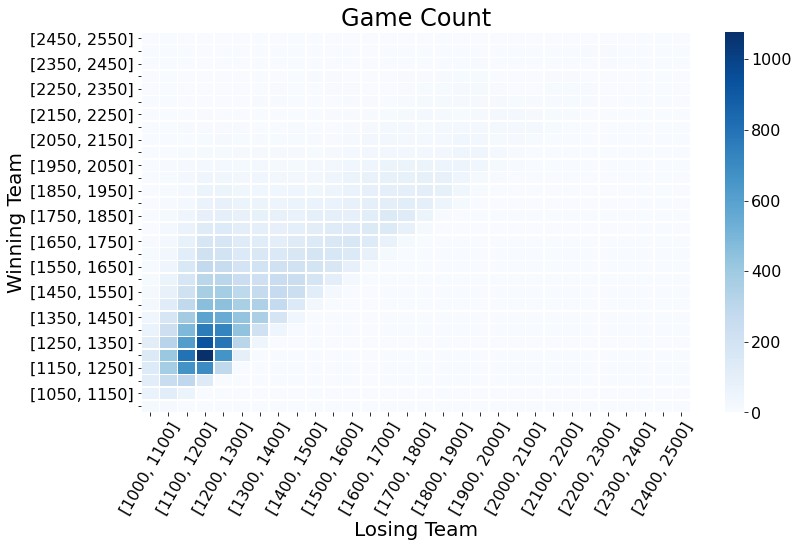

In [25]:
#Plot heatmap of game count
plt.clf()  # For clearing plot
sns.heatmap(
    game_count_array,
    cmap="Blues",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)

plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)  
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Game Count")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

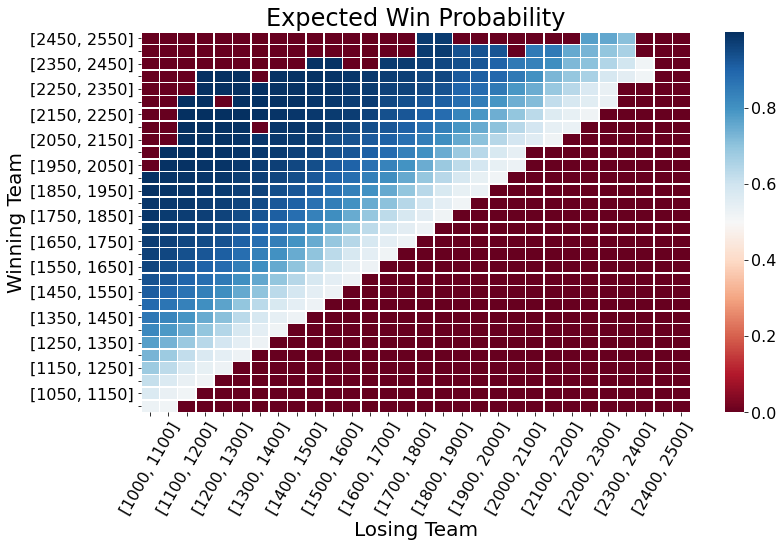

In [22]:
#Plot heatmap of expected win probability
plt.clf()  # For clearing plot
sns.heatmap(
    exp_win_prob_array,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)   
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Expected Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

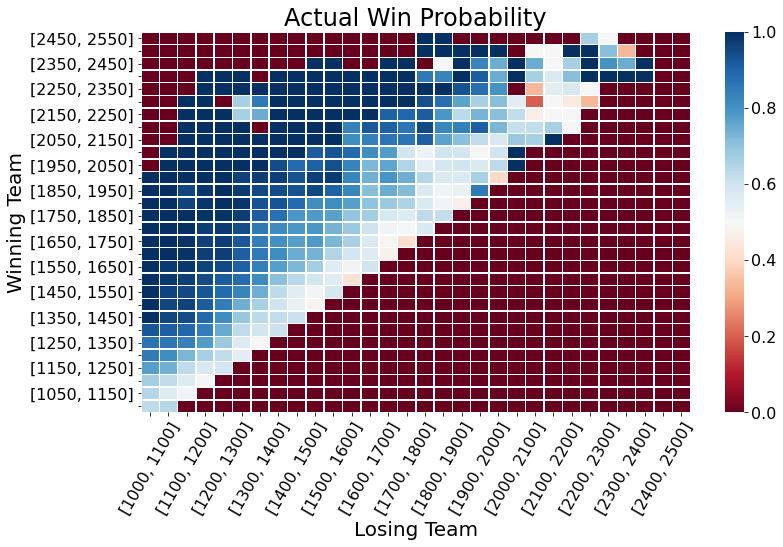

In [23]:
#Plot heatmap of actual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    actual_win_prob,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Actual Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

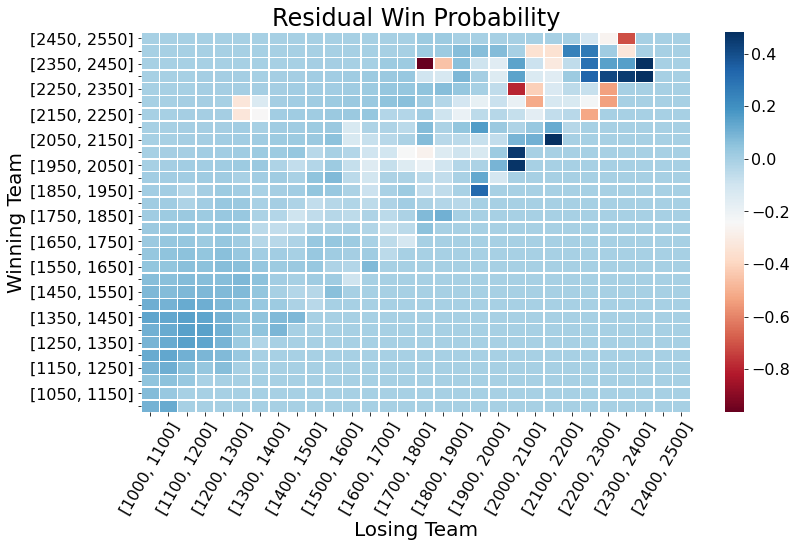

In [24]:

#Plot heatmap of residual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    residual_win_prob,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)   
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Residual Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()